In [32]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from plotting import *
from rating_create import *
from sensitivity import *
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from hypothesis import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Introduction

The average team in the NBA averaged over 80 field goal attempts per game in the 2016-17 regular season. There are two teams in a game therefore an average game in the nba saw about 160 shots. There are 1260 total games played in the NBA, meaning that there are over 120,000 shots attempted every regular season. With this many number of shots in a season, we thought it would be worthwhile to explore patterns in shots, and what affects a particular shot that is missed or made and so on.

Our data was obtained from a Kaggle user. The data contains details from shots attempted in every NBA game. The details in the data include, shot taker, shot distance, closest defender distance, game clock, shot clock, period and a few other useful information on when the shot was taken. The dataset was relatively easy to use as it was saved in a csv file format and most of the features in the data were numeric.

We decided to study whether or not there was a way to use the data in order to predict whether or not a shot made by a particular player would go in. In order to do this we had to ask a few questions of our data.
What factors affect the probability of a shot being made?
Shot distance, defender distance seemed to be two factors heavily affecting shots 
Location, dribbles did not have much influence
Is there a model to effectively predict the shot being made or missed?

The second question ended up being the capstone of our project.

Overview of Results: Having worked with three different models, we were able to correctly predict the outcome of about 62% of shots from a test data of about 40,000. The true positive rate was greater than the false positive rate for all thresholds of probabilities that we worked with.

# 2. Data


Below is a snippet of our data and the features are as described above. Data acquisition is described in the readme file.

In [33]:
raw = pd.read_csv("shot_logs.csv")
raw.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


# 3. Methedology

## Initial data Analysis & exploration

Before we started our hypothesis testing, We looked at some descriptive statistics and plots to get an understanding of the data. The mean of the FGM variable shows that 45% of the shot attempts were made. The mean and median shot distance was about 13.5 feet which is slightly closer to the basket than the free throw line which is 15 ft. Defenders are an average of 4.12 feet away which is further than we had expected. However, when considering the high frequency of shots that are made from outside the box, this distance is consistent with what we would expect. 
We started off by ploting some of the features we suspected would have influences on the result of an attempted shot. 

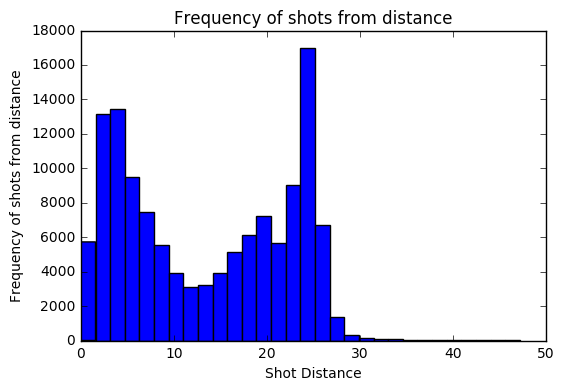

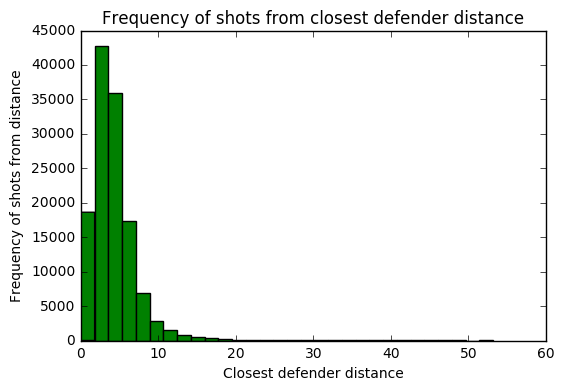

In [34]:
hist_plot(raw['SHOT_DIST'], 'Shot Distance', 'Frequency of shots from distance', 'Frequency of shots from distance')
hist_plot(raw['CLOSE_DEF_DIST'], 'Closest defender distance', 'Frequency of shots from distance', 'Frequency of shots from closest defender distance', color='g')

Next, we  used tableau to plot a scatterplot of these two features with each shot's result color labeled accordingly. This helped us visualize the correlation  of these features with the probability of making a shot. 
<img src="s1.png"> 

## Initial attempt: 
We used decision tree as our machine learning technique in this project. In our first model, we tried to use as much information as possible. Thus, we included all seemingly related columns from the data set as features in our decision tree. Those include location (home or away), shot distance, period (1-4, and overtime), number of dribbles… etc. We also created two extra features based on the data set: player offensive rating and player defensive rating. Each rating is essentially the percentage of shot the player made/defended when he was attempting or preventing a field goal. Each rating has two separated categories, one for two points field goals and one for three points ones. Due the obvious difference seen earlier in the points vs. shot plot, we realized that two point field goals have a higher probability to be made than three points and it would be less accurate to simply use one percentage for both of them. There are also some columns that we believe were not a factor in shot prediction, including player id, game id and some others. For all numerical features we applied feature engineering and divided them into four percentile subgroups: 0-25, 25-50, 50-75, 75-max (Yes, this is may not be optimal. It will be addressed later). Similar to what was done in lab7, preprocessing added all values of a feature to an array and during finalizing features, the array was sorted and percentiles were generated based on the number of inputs. Then, in feature extraction, we compared each numerical value with the value that determines percentiles and added a categorical value to all the features. The classifier then trains on parts of the data to build a decision tree. 

## Results:
As we can see, the decision tree was correctly prediction 69516 out of 80000 shots in the training data and 21692 out of 40000 shots in the test data, which are 86.9% and 54.2% respectively. Based on the decision tree, the first couple splits were made on shot distance and closest defender distance and number of dribbles also was a major split in many of the nodes in the tree. One problem we immediately noticed was the decision tree is much more accurate in predicting the training data than the test data. It was actually doing 60% better on the training data. It clearly suggested the model was over fitting the training data. To solve this problem, we decided to exclude some of the features that may not be vital or pertinent in shot predictions. To do so, we applied several hypothesis testing and other visualization tools to see if a feature is indeed important.

## Hypothesis Testing

### a. Two and Three pointer Differences
Intuitively, we believed that two point shots are much easier to make than three point ones. To test this, we ploted the following graph, where we can confirm with the differences ratio. We observed that 3 point shots occur much less often and also that 3-point shots were made less frequently than points from inside the 3-point line. This was consistent with what we believed and we confirmed that Point type should be included in our feature list for the prediction model 

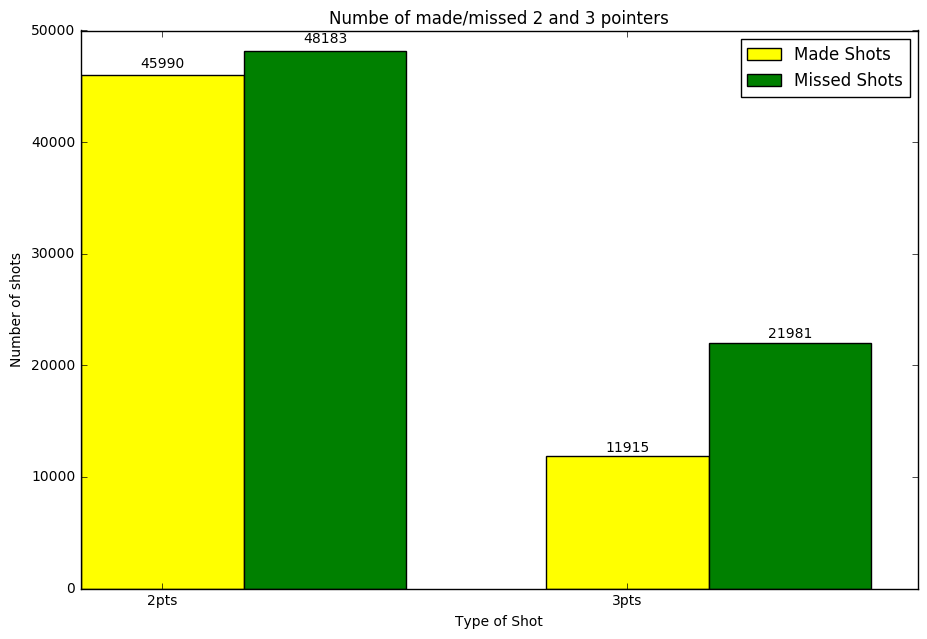

In [35]:
plot_two_vs_three()

### b. Shot Outcome vs. Defender Distance
When we use four percentiles to divide numerical values into subgroups, we do see some variation between subgroups. Thus, we chose to keep this attribute.


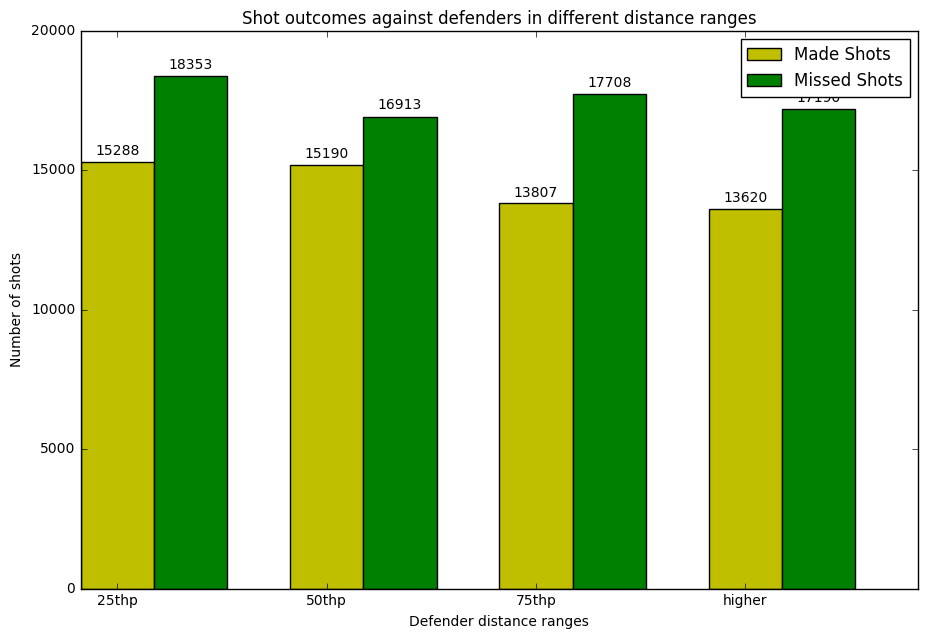

In [36]:
make_bar_graph('shot_vs_def_dist')

### c. Home Court Advantage?
We wanted to investigate whether court location had an effect on the probability of a shot going in. We started by comparing the field goal percentage of teams playing home and away

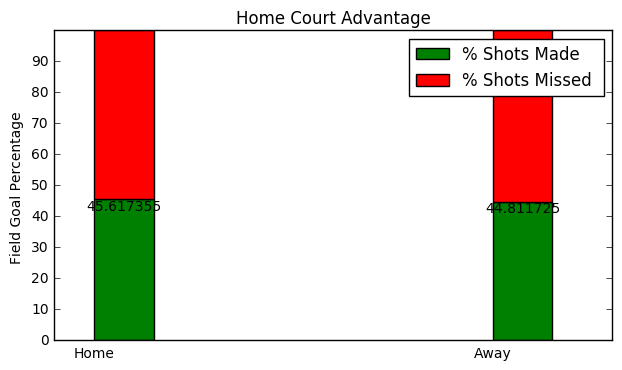

In [37]:
shots_made, shots_missed = court_adv(raw)
plot_court_advantage(shots_made, shots_missed)

We can see that on average teams at home have a slightly higher field goal percentage rate. This is consistant with what we already knew which is that home teams have a higher win percentage. However we did not find any statistical evidence that indicates the home or away location of a game has any contribution towards the probability of an individual shot going in. We reasoned that this could be because we are only considering field goals and the impact of a home court advantage could be more felt on free throws and other factors that affect a teams winning chance.  

### d. Analysis of Shot Clock Usage

We didn't really have any idea how this could contribute to the likelihood of a shot going in but we decided to check this by plotting the percentage of field goals made at each second of the timeclock. The shotclock is 24 seconds, so for each time t which is the number of seconds left on the shot clock, we get all the shots that were attempted with t time on the shot clock and calculate the percentage of shots that went in.  

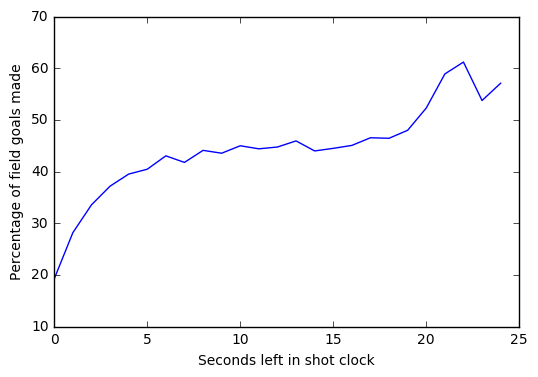

In [38]:
final = clock_fpg(raw)
plt.plot(final['sec_left'], final['FG%'])
plt.xlabel("Seconds left in shot clock")
plt.ylabel("Percentage of field goals made")
plt.show()

We can see that the field percentage goal has a clear postive correlation with the time left on the shot clock. This intuitively makes sense as shots with little left time left on the clock will tend to be rushed and have lower probability of going in.

## Updated model:

From our hypothesis, analysis we were able to discard court location as a relevant feature and ascertain that shot distance,closest defender distance and time left on the shot clock have at least some contribution to the probability of a shot going in.In this updated version of model, we excluded the features discussed above and now the system is left with period,shot distance, point type, shot clock, closest defender distance, player offensive percentage and player defensive percentage. Those features were also divided into four categories in the same way as the first version of the model. 

## Results:
As we can see, the decision tree was correctly prediction 49642 out of 80000 shots in the training data and 24360 out of 40000 shots in the test data, which are 62.1% and 60.9% respectively. Comparing the results to that of our initial model, we first notice that accuracy in successfully predicting training data decreased from almost 87% to a little over 62% (~40% decrease). But this is expected and even desired since we were trying to resolve the problem of over fitting. At the same time, we see accuracy in test data increased from 54.2% to 60.9%, which is a little less than 15% increase in accuracy improvement. Another point worth noting is that the accuracy on training data and test data is now very close to each other, which suggests that the decision tree is predicting in a very similar way for both of them. In addition, based on the decision tree, the first couple splits were made on shot distance and closest defender distance followed by defender defensive percentage, player shot percentage. Comparing to the initial model, the first two splits are happening on the exact same feature but the next several splits are different. This is likely due to removal of the feature we identified as unimportant in analyzing features.

## Potential problems:
Now that we have solved the problem of over fitting, we seek to further improve our model. One potential problem of our model is that all numerical values were broken into four subgroups in an arbitrary way as we simply picked the thresholds based on percentile and append the percentile as value for the feature. This may raise several problems. First of all, the percentile may not be a good splitting point. Fifty percentile may not be a good indicator of whether a shot will be made or missed. For example, it is possible that a good splitting point for shot distance is at 36 percentile and the decision tree was not able to split on that percentile but had to choose 25 or 50 percentile. Second of all, the subgroups of the feature may not be equally divided. Again, in the example of shot distance, the four groups we have are evenly distributed based on percentile, yet in reality, there might be more deciding subgroups when the distance is close to the basket and much fewer when the distance is further away from it. Thus, one way to improve our model is to keep all feature values as numbers and let the classifier to decide where would be an ideal splitting point. 


## Continuous model:
In this version of model, we keep all features in the last model and, in addition, we assign them with numerical values. Another improvement we added was to create player offensive/defensive rating based only on the first two thirds of the season. The same games were used as training data as well and the last one third of the season is now used as test data for decision tree. Although we believed the influence of including all data points for rating calculation is minor, doing so guarantees absolute separation of training data and test data. 

## Results:
As we can see, the decision tree was correctly prediction 54796 out of 88065 shots in the training data and 24865 out of 40004 shots in the test data, which are 62.2% and 62.2% respectively. Comparing the results to that of our initial model, we first notice that accuracy in successfully predicting training data changed from 62.1% to 62.2% and accuracy in predicting test data increased from 60.9% to 62.2%.  The increase in accuracy was not as large as we expected. Furthermore, based on the decision tree, the first couple splits were made on shot distance and closest defender distance followed by defender defensive percentage, player shot percentage. Comparing to our second model, the major splits were exactly the same. The only difference is that, in some part of the tree, we see a second or even a third split on the same feature. 


### Part of our decision tree:

<img src ="s3.png">

## Area Under Curve:

In addition to accuracy we looked at the sensitivity of our classifier. The sensitivity refers to the how well the classifier does on shots that are made and it checks this for different thresholds of probability. The probability of the shot’s is determined by our decision tree. For each shot we find the probability of whether or not that shot would go in depending on the attributes of that shot. In the sensitivity.py file calculate the true and false positive rates for different thresholds and plot the graph.

From observing the area under the curve for our sensitivity measure, we can see that our model seems to be doing well when predicting the shots. The true positive rates is better than randomly guessing work.

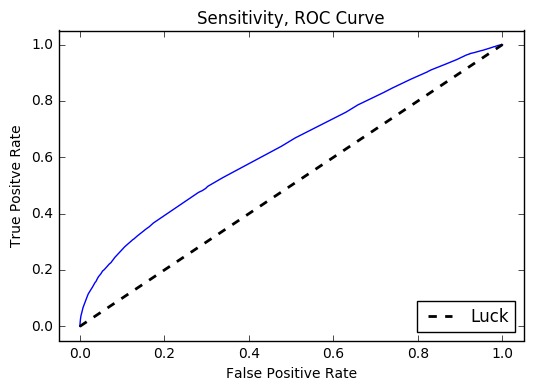

In [39]:
ROCurve()

# 4. Related Work

We were able to find a few projects that closely matched the objectives of ours. One specific project that we found was presented at the MIT Sloan Sports Analytics conference. The project was intended to find new measures to judge the quality of a particular shot and the ability of a player to make a given shot that they are taking. The authors claim that two different shots taken from the same distance can have different qualities. “Intuitively, we can read a play-by-play line saying “Player X misses 20-foot jumper” but understand that not all 20-footers are not created the same. If the player is standing still with no one within 10 feet, that is an entirely different shot than if the player is fading off the dribble with two defenders in his face.” They use datasets that have to measure quality of the shots based on their different features (ESQ). To judge the ability of the player to make the shot, this measures how much better than expectation that a player/a team is shooting (EFG+). The findings of the result made very much intuitive sense, as the teams and players that had the highest rankings in ESQ and EFG+ were the teams that were contenders in the playoffs and players regarded as the really good shooters. (Miami heat was number one for teams and and Kyle Korver was number one for players)

The refrence for this work can be found at http://www.sloansportsconference.com/wp-content/uploads/2014/02/2014-SSAC-Quantifying-Shot-Quality-in-the-NBA.pdf

# 5. Conclusion

In this project, we started with a simple model with some assumptions and some initial data analysis and adapted our model to a more reasonable and well fit one gradually. The first model was trying to incorporate all available features in the model and resulted an over fitting. By conducting statistical analysis we were able to reduce the number of features in our model. As the result, the problem of over fitting was resolved. To further improve our mode, we then released some of our assumptions, such as creating categorical values for numerical features. The model improved as we adapted but the percentage increase was much lower than our expectation. Overall, we believe we successfully determined the important features of the model and improved accuracy by adapting our model based on strict reasoning. 

### Potential future work on this may include:
1). Finding more available data for training and test. Since NBA API was closed, we were unable to obtain similar data of other seasons for further analysis.
2). Try other classifier on the data. One interesting classifier is perceptron since most, if not all, features in the data set is numerical and perceptron could easily take advantage of this fact. However, one thing to keep in mind is that a perceptron may not necessarily converge and produce meaningful results.

### Contributions to the work:

Abeneazer: 25%
Degena: 37.5%
Carlton: 37.5%